# Imports

In [45]:
train_url = 'https://raw.githubusercontent.com/sidt-ai/data-science-competitions/main/hackerearth/texas_inst_hiring/circuit_voltage/data/raw/train.csv'
test_url = 'https://raw.githubusercontent.com/sidt-ai/data-science-competitions/main/hackerearth/texas_inst_hiring/circuit_voltage/data/raw/test.csv'

In [46]:
%%capture
!python3 -m pip install --quiet --upgrade sklearn

In [66]:
import time
import gc
gc.enable()

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option("precision", 4)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

SEED = 2311

In [48]:
train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

# Data Summary

In [49]:
train.head()

,ID,time,V(in),V(out),V(n001),V(n002),V(n003),V(n004),V(n005),Ix(U1:In+),Ix(U1:In-)
0,0x0,0.0000e+00,0.0000e+00,1.5900e-18,2.9600e-20,4.0000e-19,9.9500e-19,-5.0800e-16,-3.1100e-19,-4.0000e-28,0.0000e+00
1,0x1,1.0700e-08,6.7300e-05,-4.8700e-08,1.5900e-05,2.5300e-06,1.1100e-06,2.9100e-07,1.6900e-06,-1.2000e-09,2.4000e-09
2,0x2,2.1400e-08,1.3500e-04,-2.4400e-08,3.5500e-05,8.0800e-06,3.8200e-06,2.6000e-07,6.8900e-06,-2.1500e-09,4.3000e-09
3,0x3,3.2100e-08,2.0200e-04,7.2900e-08,5.9100e-05,1.6600e-05,8.1500e-06,-9.2100e-08,1.5600e-05,-2.8500e-09,5.7000e-09
4,0x4,4.2900e-08,2.6900e-04,2.4300e-07,8.6400e-05,2.8200e-05,1.4100e-05,-7.6600e-07,2.7800e-05,-3.3000e-09,6.6000e-09


In [50]:
test.head()

,ID,time,V(in),V(n001),V(n002),V(n003),V(n004),V(n005),Ix(U1:In+),Ix(U1:In-)
0,0x15f,0.0244,3.51,-0.0011,-3.51,8.4000e-05,-4.08,-0.0010,1.5200e-11,-1.5500e-11
1,0x160,0.0245,3.01,-0.0011,-3.01,8.8700e-05,-3.58,-0.0010,1.5600e-11,-1.5800e-11
2,0x161,0.0246,2.51,-0.0012,-2.51,9.2500e-05,-3.06,-0.0010,1.5900e-11,-1.6200e-11
3,0x162,0.0247,2.00,-0.0012,-2.00,9.5400e-05,-2.54,-0.0010,1.6300e-11,-1.6600e-11
4,0x163,0.0248,1.48,-0.0012,-1.48,9.7400e-05,-2.01,-0.0011,1.6700e-11,-1.7000e-11


In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          351 non-null    object 
 1   time        351 non-null    float64
 2   V(in)       351 non-null    float64
 3   V(out)      351 non-null    float64
 4   V(n001)     351 non-null    float64
 5   V(n002)     351 non-null    float64
 6   V(n003)     351 non-null    float64
 7   V(n004)     351 non-null    float64
 8   V(n005)     351 non-null    float64
 9   Ix(U1:In+)  351 non-null    float64
 10  Ix(U1:In-)  351 non-null    float64
dtypes: float64(10), object(1)
memory usage: 30.3+ KB


In [52]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          88 non-null     object 
 1   time        88 non-null     float64
 2   V(in)       88 non-null     float64
 3   V(n001)     88 non-null     float64
 4   V(n002)     88 non-null     float64
 5   V(n003)     88 non-null     float64
 6   V(n004)     88 non-null     float64
 7   V(n005)     88 non-null     float64
 8   Ix(U1:In+)  88 non-null     float64
 9   Ix(U1:In-)  88 non-null     float64
dtypes: float64(9), object(1)
memory usage: 7.0+ KB


In [53]:
features = list(test.columns)
features.remove('ID')

target = 'V(out)'

# 1. Correlation and Feature Selection

In [54]:
train.corr()[target][features]

time          0.1636
V(in)         0.1952
V(n001)      -0.0282
V(n002)      -0.5099
V(n003)       0.5091
V(n004)      -0.3199
V(n005)       0.5089
Ix(U1:In+)    0.0549
Ix(U1:In-)   -0.0544
Name: V(out), dtype: float64

In [55]:
abs(train.corr()[target][features]).sort_values()

V(n001)       0.0282
Ix(U1:In-)    0.0544
Ix(U1:In+)    0.0549
time          0.1636
V(in)         0.1952
V(n004)       0.3199
V(n005)       0.5089
V(n003)       0.5091
V(n002)       0.5099
Name: V(out), dtype: float64

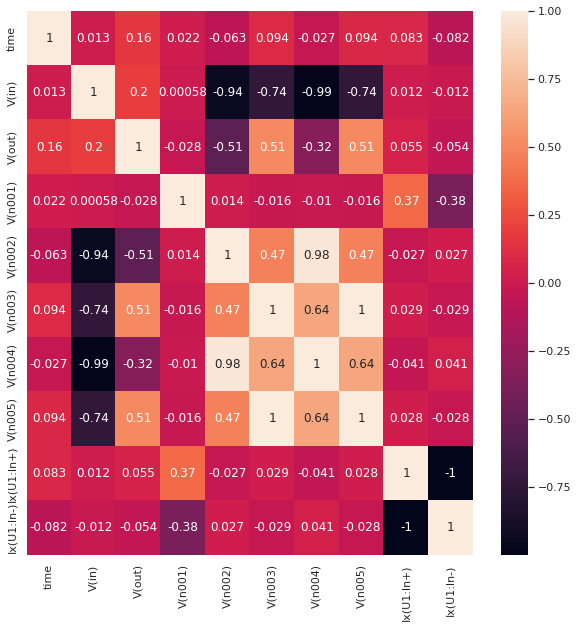

In [56]:
plt.figure(figsize=(10, 10))
sns.heatmap(train.corr(), annot=True)

Ix(U1:In-) and Ix(U1:In+) have perfect negative correlation. Hence, only one of them is needed.  
V(in) has almost perfect negative correlation with V(n002) and V(n004). Hence, only V(in) is needed.  
V(n003) and V(n005) have perfect positive correlation. Hence, only one of them is needed.

In [57]:
features.remove('Ix(U1:In-)')
features.remove('V(n002)')
features.remove('V(n004)')
features.remove('V(n005)')

In [58]:
features

['time', 'V(in)', 'V(n001)', 'V(n003)', 'Ix(U1:In+)']

# 2. Linear modelling

### Linear Regression

In [59]:
X = train[features]
y = train[target]

In [60]:
xtrain, xval, ytrain, yval = train_test_split(X, y, shuffle=True, test_size=0.33, 
                                              random_state=SEED)

In [61]:
model1 = LinearRegression().fit(xtrain, ytrain)

In [62]:
model1.score(xval, yval)

0.9996057482469319

In [63]:
model1.fit(X, y)
preds1 = model1.predict(test[features])

In [64]:
sub1 = pd.DataFrame({'ID': test.ID, target: preds1})
sub1.to_csv('sub1.csv', index=False)

In [65]:
!head sub1.csv

ID,V(out)
0x15f,3.611356776250913
0x160,3.116048407682956
0x161,2.6207092657710644
0x162,2.1154478548289957
0x163,1.60029234447871
0x164,1.080567407048921
0x165,0.7171506934169035
0x166,0.5346785826017152
0x167,0.35282146154464844


# 3. Non-linear modelling

### Neural Network

In [69]:
model2 = MLPRegressor(hidden_layer_sizes=(8, 4), activation='relu',
                      solver='adam', batch_size=32, random_state=SEED,
                      early_stopping=True, validation_fraction=0.33,
                      tol=1e-4, n_iter_no_change=20, verbose=True)

In [ ]:
model2.fit(X, y)

In [71]:
preds2 = model2.predict(test[features])

In [72]:
sub2 = pd.DataFrame({'ID': test.ID, target: preds2})
sub2.to_csv('sub2.csv', index=False)

In [73]:
!head sub2.csv

ID,V(out)
0x15f,3.4890527722002327
0x160,2.982242932986038
0x161,2.4754341598120346
0x162,1.9584897060226678
0x163,1.4354494682615486
0x164,0.9391227106209956
0x165,0.6250724367471177
0x166,0.3791472326506877
0x167,0.2297966290166069


### Random Forest

In [74]:
model3 = RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=SEED)

In [75]:
model3.fit(xtrain, ytrain)

RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=2311)

In [77]:
model3.score(xval, yval)

0.9994180263795323

In [78]:
model3.fit(X, y)
preds3 = model3.predict(test[features])

In [79]:
sub3 = pd.DataFrame({'ID': test.ID, target: preds3})
sub3.to_csv('sub3.csv', index=False)

In [80]:
!head sub3.csv

ID,V(out)
0x15f,3.5377999999999967
0x160,2.999799999999994
0x161,2.5002666666666666
0x162,1.9675333333333314
0x163,1.4750799999999997
0x164,0.9573133333333325
0x165,0.5645466666666664
0x166,0.4220866666666663
0x167,0.22590666666666637
